First go at definining the use case.

In [131]:
import pandas as pd
import numpy as np
from cytominer_eval.transform import metric_melt
from pycytominer.cyto_utils import infer_cp_features
import matplotlib.pyplot as plt

In [132]:
# import
df = pd.read_csv('lincs_modz_consensus_data.csv')

In [133]:
features = infer_cp_features(df)
meta_features = infer_cp_features(df, metadata=True)

## Select compounds
First we select a subset of data. For now, we only focus on one concentration of each compound and only include the negative DMSO wells and not the positive controls.
We also only keep compounds that have a known MOAs.
And then we only keep MOAs that have more than one compound.

In [134]:
# 1. Only keep the dose 6 and dose 0 (DMSO)
df = df.query("Metadata_dose_recode == 0 | Metadata_dose_recode == 6 ")
# 2. Get rid of all compounds that have unknown MOAs
df =  df.query("Metadata_moa != 'unknown'")
# 3. Drop all single Moas
ls = df.Metadata_moa.value_counts() != 1
keys = ls[ls].keys()
df = df[df["Metadata_moa"].isin(keys)].reset_index(drop=True)


In [135]:
melt = metric_melt(df, features, ['Metadata_broad_sample', 'moa'], eval_metric='precision_recall').sort_values(
        by="similarity_metric", ascending=False)
grouped = melt.groupby(['Metadata_broad_sample_pair_a'])

In [136]:
def index_hits(df):
    df.reset_index(drop = True, inplace=True)
    df['rank'] = range(len(df))
    moa = a.moa_pair_a.iloc[0]
    df['same_moa'] = df['moa_pair_b'] == moa
    df.drop(columns=['pair_a_index', 'pair_b_index', 'similarity_metric'], inplace=True)
    return df

In [137]:
indexes = grouped.apply(lambda x: index_hits(x))

In [138]:
indexes.reset_index(drop=True, inplace=True)
indexes.rename(columns={'Metadata_broad_sample_pair_a': 'target_compound', 'Metadata_broad_sample_pair_b':'match_compound', 'moa_pair_a':'target_moa', 'moa_pair_b':'match_moa'}, inplace=True)

In [139]:
indexes.head()

,target_compound,target_moa,match_compound,match_moa,rank,same_moa
0,BRD-A00218260-001-03-4,sterol demethylase inhibitor,BRD-K03390685-001-01-7,mek inhibitor,0,False
1,BRD-A00218260-001-03-4,sterol demethylase inhibitor,BRD-K01824921-001-18-5,adenosine receptor antagonist,1,False
2,BRD-A00218260-001-03-4,sterol demethylase inhibitor,BRD-A00376169-001-01-6,neprilysin inhibitor,2,False
3,BRD-A00218260-001-03-4,sterol demethylase inhibitor,BRD-K33610132-001-02-9,egfr inhibitor,3,False
4,BRD-A00218260-001-03-4,sterol demethylase inhibitor,BRD-K13296708-001-05-8,cannabinoid receptor antagonist,4,False


In [140]:
def calc_hits(df, only_first = False):
    group = df.groupby(['target_compound'])
    index_ls = group.apply(lambda x: find_hits(x, only_first = only_first))
    return index_ls

def find_hits(df, only_first):
    #print(df.target_compound.iloc[0])
    index_ls = df[df['same_moa'] == True]['rank'].tolist()
    if len(index_ls) == 0:
            print(df.target_compound.iloc[0])
    if only_first:
        return index_ls[0]
    else:
        return index_ls

In [141]:
index_series = calc_hits(indexes)
index_first_series = calc_hits(indexes, only_first=True)

In [142]:
index_flat = [item for sublist in index_series.tolist() for item in sublist]
index_first_flat = index_first_series.tolist()

In [151]:
# randomized
df_copy = df.copy()
df_copy[features] = df_copy[features].iloc[np.random.permutation(len(df))].reset_index(drop=True)

In [ ]:
ran_melt = metric_melt(df_copy, features, ['Metadata_broad_sample', 'moa'], eval_metric='precision_recall').sort_values(
        by="similarity_metric", ascending=False)
ran_grouped = ran_melt.groupby(['Metadata_broad_sample_pair_a'])
ran_indexes = ran_grouped.apply(lambda x: index_hits(x))
ran_indexes.reset_index(drop=True, inplace=True)
ran_indexes.rename(columns={'Metadata_broad_sample_pair_a': 'target_compound', 'Metadata_broad_sample_pair_b':'match_compound', 'moa_pair_a':'target_moa', 'moa_pair_b':'match_moa'}, inplace=True)

In [ ]:
ran_index_series = calc_hits(ran_indexes)
ran_index_first_series = calc_hits(ran_indexes, only_first=True)
ran_index_flat = [item for sublist in ran_index_series.tolist() for item in sublist]
ran_index_first_flat = ran_index_first_series.tolist()

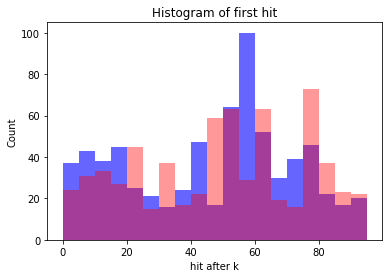

In [160]:
bins = np.arange(0,100,5)
plt.style.use({'figure.facecolor':'white'})
plt.hist(index_flat, bins, alpha=0.6, color='blue')
plt.hist(ran_index_flat, bins,alpha=0.4, color='red')
plt.xlabel('hit after k')
plt.ylabel('Count')
plt.title('Histogram of first hit')
plt.show()

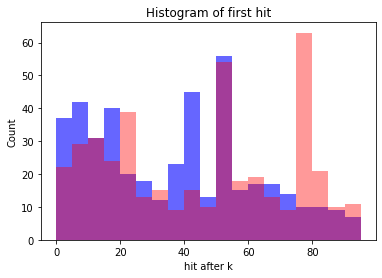

In [161]:
bins = np.arange(0,100,5)
plt.style.use({'figure.facecolor':'white'})
plt.hist(index_first_flat, bins, alpha=0.6, color='blue')
plt.hist(ran_index_first_flat, bins,alpha=0.4, color='red')
plt.xlabel('hit after k')
plt.ylabel('Count')
plt.title('Histogram of first hit')
plt.show()